## EECE5644 Assignment 3 - Question 1

#### Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

np.random.seed(66)


#### Data Generator for Certain Distribution

In [4]:
class DataGenerator:
    """Generate data from 4-class Gaussian mixture"""
    
    def __init__(self):
        self.C = 4
        self.priors = np.ones(self.C) / self.C
        
        # Define mean vectors for each class (3D)
        self.means = [
            np.array([0, 0, 0]),
            np.array([3, 3, 0]),
            np.array([0, 3, 3]),
            np.array([3, 0, 3])
        ]
        
        # Define covariance matrices
        self.covariances = [
            np.array([[1.5, 0.3, 0.2],
                     [0.3, 1.5, 0.3],
                     [0.2, 0.3, 1.5]]),
            
            np.array([[1.2, -0.2, 0.1],
                     [-0.2, 1.2, -0.2],
                     [0.1, -0.2, 1.2]]),
            
            np.array([[1.3, 0.2, -0.3],
                     [0.2, 1.3, 0.2],
                     [-0.3, 0.2, 1.3]]),
            
            np.array([[1.4, -0.3, 0.2],
                     [-0.3, 1.4, -0.1],
                     [0.2, -0.1, 1.4]])
        ]
        
    def generate_data(self, n_samples):
        """Generate n_samples from the mixture distribution"""
        X = []
        y = []
        
        n_per_class = np.random.multinomial(n_samples, self.priors)
        
        for class_idx in range(self.C):
            samples = multivariate_normal.rvs(
                mean=self.means[class_idx],
                cov=self.covariances[class_idx],
                size=n_per_class[class_idx]
            )
            
            if n_per_class[class_idx] == 1:
                samples = samples.reshape(1, -1)
            
            X.append(samples)
            y.append(np.full(n_per_class[class_idx], class_idx))
        
        X = np.vstack(X)
        y = np.concatenate(y)
        
        indices = np.random.permutation(len(y))
        return X[indices], y[indices]
    
    def map_classify(self, X):
        """Apply MAP classification rule"""
        n_samples = X.shape[0]
        posteriors = np.zeros((n_samples, self.C))
        
        for i in range(n_samples):
            likelihoods = np.zeros(self.C)
            for c in range(self.C):
                likelihoods[c] = multivariate_normal.pdf(
                    X[i], 
                    mean=self.means[c], 
                    cov=self.covariances[c]
                )
            posteriors[i] = likelihoods * self.priors
            posteriors[i] /= posteriors[i].sum()
        
        return np.argmax(posteriors, axis=1)

#### MLP Cross Validation

In [5]:
def cross_validate(X_train, y_train, perceptron_range, n_folds=10, n_restarts=3):
    """Perform k-fold cross-validation"""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_scores = {p: [] for p in perceptron_range}
    
    print(f"  Performing {n_folds}-fold cross-validation...")
    
    for P in perceptron_range:
        fold_accuracies = []
        
        for train_idx, val_idx in kf.split(X_train):
            X_fold_train = X_train[train_idx]
            y_fold_train = y_train[train_idx]
            X_fold_val = X_train[val_idx]
            y_fold_val = y_train[val_idx]
            
            best_score = -np.inf
            
            for restart in range(n_restarts):
                model = MLPClassifier(
                    hidden_layer_sizes=(P,),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=restart
                )
                
                try:
                    model.fit(X_fold_train, y_fold_train)
                    score = model.score(X_fold_val, y_fold_val)
                    
                    if score > best_score:
                        best_score = score
                except:
                    continue
            
            if best_score > -np.inf:
                fold_accuracies.append(best_score)
        
        cv_scores[P] = fold_accuracies
    
    avg_scores = {p: np.mean(scores) if scores else 0 
                 for p, scores in cv_scores.items()}
    
    best_P = max(avg_scores, key=avg_scores.get)
    
    print(f"  Best P: {best_P} (Avg Accuracy: {avg_scores[best_P]:.4f})")
    
    return best_P, avg_scores

#### MLP Model Training

In [6]:
def train_mlp(X_train, y_train, n_perceptrons, n_restarts=10):
    # Train MLP with multiple restarts
    best_log_likelihood = -np.inf
    best_model = None
    
    print(f"  Training MLP with {n_perceptrons} perceptrons...")
    
    for restart in range(n_restarts):
        model = MLPClassifier(
            hidden_layer_sizes=(n_perceptrons,),
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=restart
        )
        
        try:
            model.fit(X_train, y_train)
            
            proba = model.predict_proba(X_train)
            log_likelihood = np.sum(np.log(proba[np.arange(len(y_train)), 
                                                 y_train] + 1e-10))
            
            if log_likelihood > best_log_likelihood:
                best_log_likelihood = log_likelihood
                best_model = model
        except:
            continue
    
    return best_model


1. Generating Datasets...
   Training set: 100 samples
   Training set: 500 samples
   Training set: 1000 samples
   Training set: 5000 samples
   Training set: 10000 samples
   Test set: 100000 samples

2. Computing Theoretical Optimal Classifier...
   Theoretical Error: 0.0906 (9.06%)

3. Processing Training Set: 100 samples
--------------------------------------------------------------------------------
  Performing 10-fold cross-validation...
  Best P: 15 (Avg Accuracy: 0.9000)
  Training MLP with 15 perceptrons...
  Test Error: 0.1208 (12.08%)

3. Processing Training Set: 500 samples
--------------------------------------------------------------------------------
  Performing 10-fold cross-validation...
  Best P: 7 (Avg Accuracy: 0.9160)
  Training MLP with 7 perceptrons...
  Test Error: 0.1021 (10.21%)

3. Processing Training Set: 1000 samples
--------------------------------------------------------------------------------
  Performing 10-fold cross-validation...
  Best P: 3 (Av

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/question1_results.png'

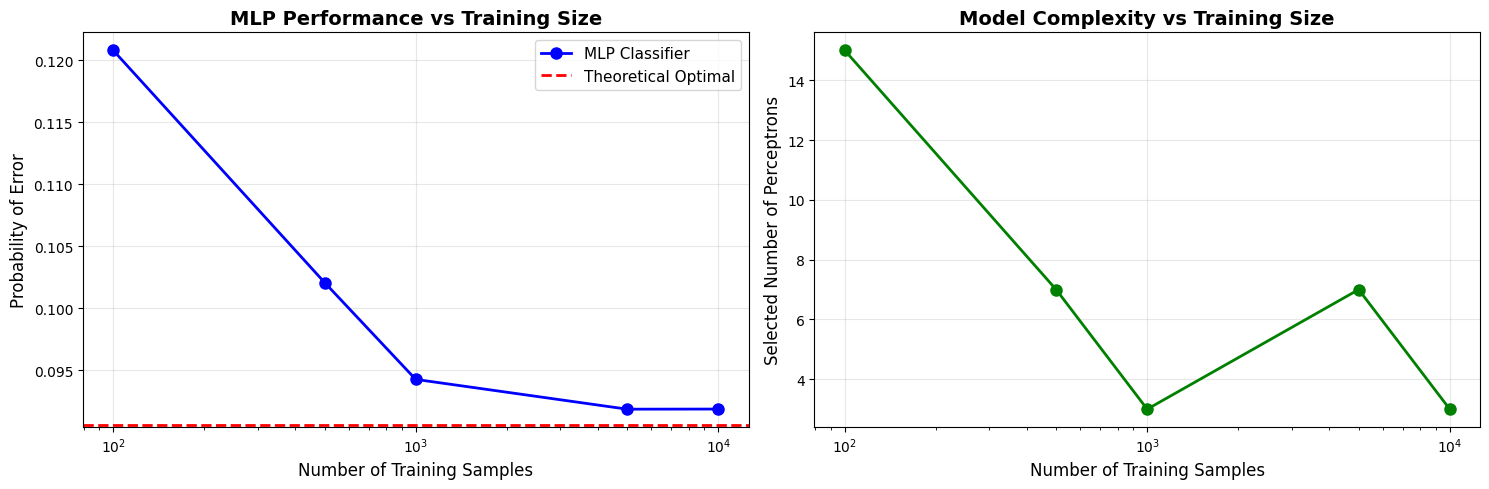

In [ ]:
data_gen = DataGenerator()
    
# Generate datasets
print("\n1. Generating Datasets...")
train_sizes = [100, 500, 1000, 5000, 10000]
test_size = 100000

train_datasets = {}
for size in train_sizes:
    X, y = data_gen.generate_data(size)
    train_datasets[size] = (X, y)
    print(f"   Training set: {size} samples")

X_test, y_test = data_gen.generate_data(test_size)
print(f"   Test set: {test_size} samples")

# Theoretical optimal
print("\n2. Computing Theoretical Optimal Classifier...")
y_test_map = data_gen.map_classify(X_test)
theoretical_error = np.mean(y_test != y_test_map)
print(f"   Theoretical Error: {theoretical_error:.4f} ({theoretical_error*100:.2f}%)")

# Model selection and training
results = {}
perceptron_range = [1, 2, 3, 5, 7, 10, 15, 20]

for train_size in train_sizes:
    print(f"\n3. Processing Training Set: {train_size} samples")
    print("-"*80)
    
    X_train, y_train = train_datasets[train_size]
    
    # Cross-validation
    best_P, cv_scores = cross_validate(X_train, y_train, perceptron_range)
    
    # Train final model
    model = train_mlp(X_train, y_train, best_P)
    
    # Evaluate
    y_pred = model.predict(X_test)
    test_error = np.mean(y_test != y_pred)
    
    results[train_size] = {
        'best_P': best_P,
        'test_error': test_error
    }
    
    print(f"  Test Error: {test_error:.4f} ({test_error*100:.2f}%)")

# Plot results
print("\n4. Generating Plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

test_errors = [results[size]['test_error'] for size in train_sizes]
best_Ps = [results[size]['best_P'] for size in train_sizes]

axes[0].semilogx(train_sizes, test_errors, 'bo-', linewidth=2, 
                    markersize=8, label='MLP Classifier')
axes[0].axhline(y=theoretical_error, color='r', linestyle='--', 
                linewidth=2, label='Theoretical Optimal')
axes[0].set_xlabel('Number of Training Samples', fontsize=12)
axes[0].set_ylabel('Probability of Error', fontsize=12)
axes[0].set_title('MLP Performance vs Training Size', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

axes[1].semilogx(train_sizes, best_Ps, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Training Samples', fontsize=12)
axes[1].set_ylabel('Selected Number of Perceptrons', fontsize=12)
axes[1].set_title('Model Complexity vs Training Size', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('outputs/question1_results.png', dpi=300, bbox_inches='tight')
# print("Saved: question1_results.png")



#### Summary

In [ ]:
print("SUMMARY")
print("="*80)
print(f"{'Train Size':<15} {'Best P':<10} {'Test Error':<15} {'Error %':<15}")
print("-"*80)
print(f"{'Theoretical':<15} {'-':<10} {theoretical_error:<15.4f} "
        f"{theoretical_error*100:<15.2f}")
for size in train_sizes:
    print(f"{size:<15} {results[size]['best_P']:<10} "
            f"{results[size]['test_error']:<15.4f} "
            f"{results[size]['test_error']*100:<15.2f}")


SUMMARY
Train Size      Best P     Test Error      Error %        
--------------------------------------------------------------------------------
Theoretical     -          0.0906          9.06           
100             15         0.1208          12.08          
500             7          0.1021          10.21          
1000            3          0.0943          9.43           
5000            7          0.0919          9.19           
10000           3          0.0919          9.19           
